# Translateron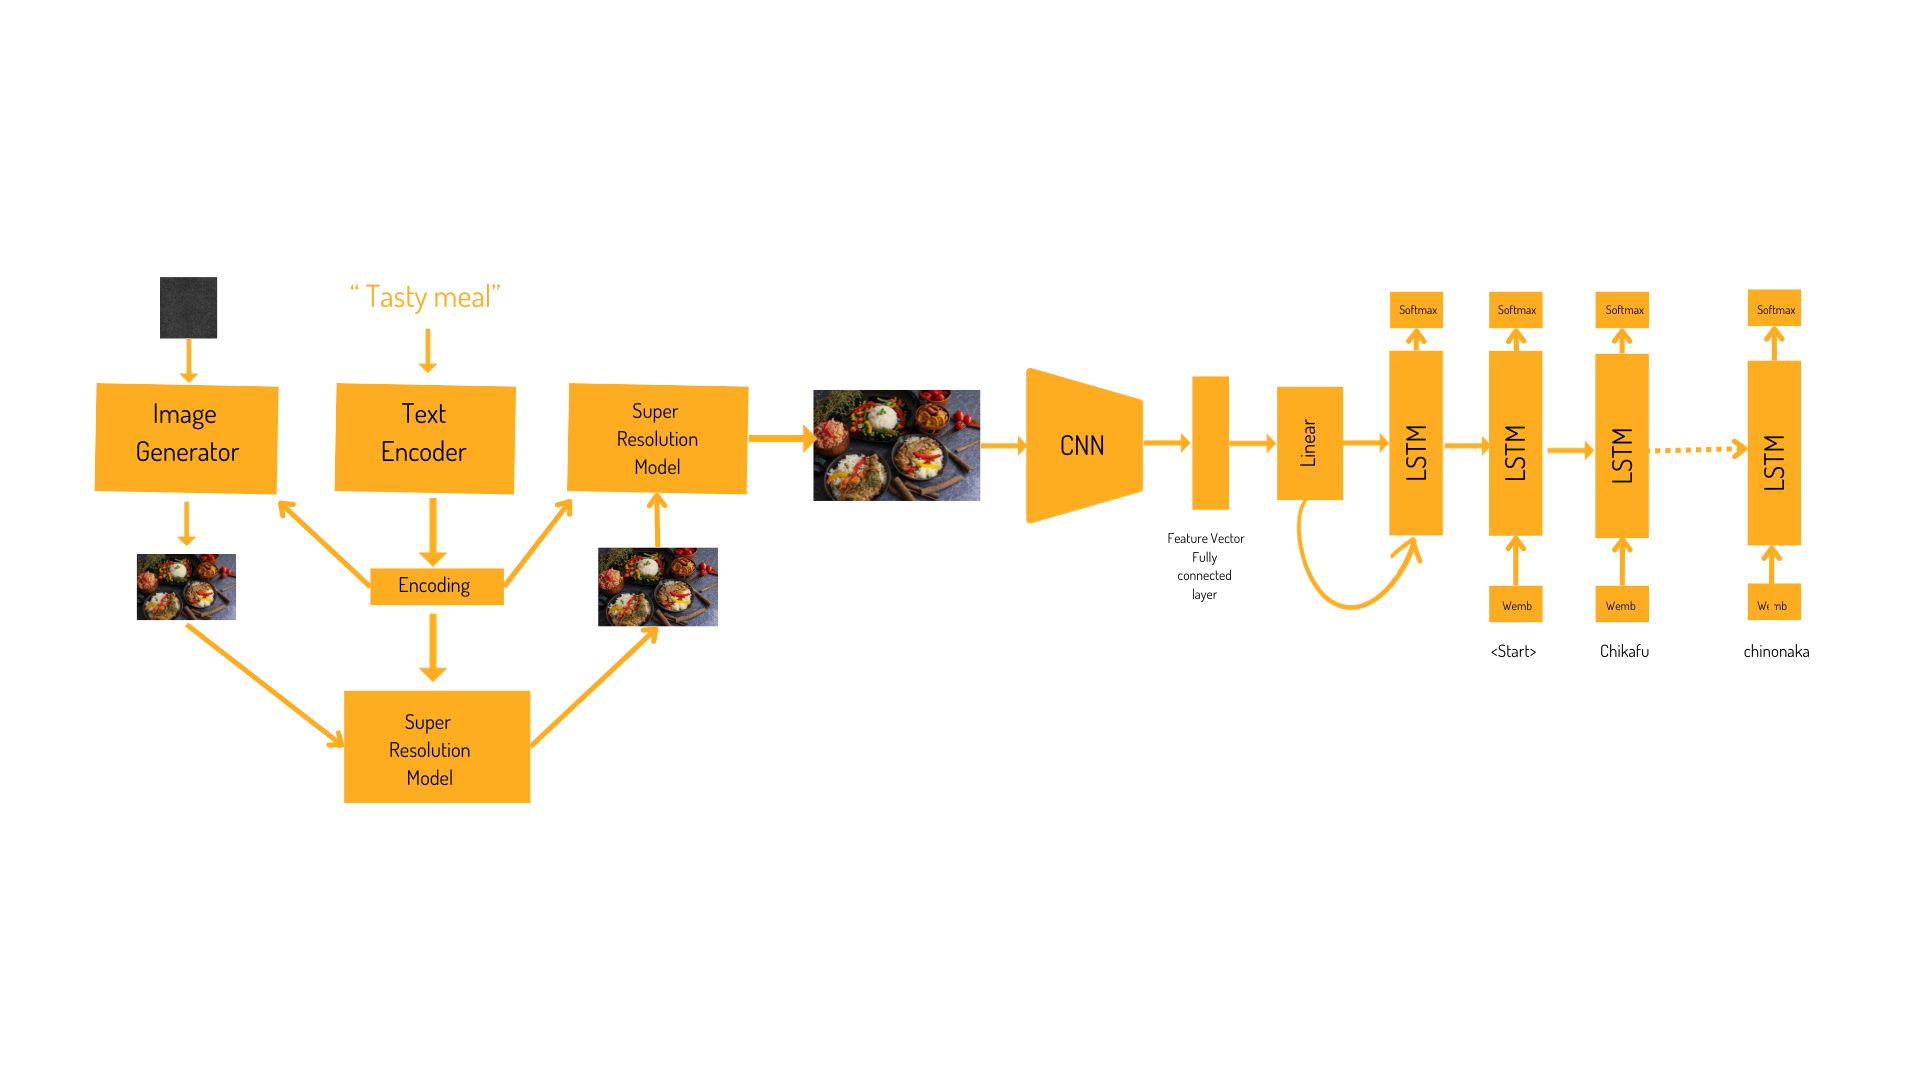

Translateron is a bidirectional text-to-image machine translation system that allows for seamless translation between images and text which is an extremely useful feature in building universal language systems. Translateron is inspired to solve the limited availability of machine translation systems for low-resource languages especially those in Africa. Through the use of an a architecture that combines a diffusion model and a CNN-LSTM model, the translateron, makes in possible for the first time to use dynamic mono-lingual datasets that simply describe pictures in one language to optimize a universal language model. This is extremely important as it lowers the required skill level for data creation for machine translation systems for low-resource languages.


In [103]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Text To Image Model**

Installations

In [104]:
!pip install pillow

Importations

In [105]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2

In [106]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

Stable Difusion Pretrained Open-source Model

In [107]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token='your_hugging_face_auth_token', guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found
Keyword arguments {'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [108]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image

Generating images from prompts

Token indices sequence length is longer than the specified maximum sequence length for this model (173 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["stretched arms, her carefree laughter echoing in the air. envision the raindrops suspended in mid - air, their trajectories frozen in time, highlighting the dynamic energy of the playful moment. the ambient light, softened by the rain clouds, imparts a gentle glow to the surroundings, enhancing the magical and whimsical atmosphere. capture the authenticity of the child's expression, the sparkle in her eyes, and the subtle reflections of the rain - soaked environment on her radiant face."]


  0%|          | 0/35 [00:00<?, ?it/s]

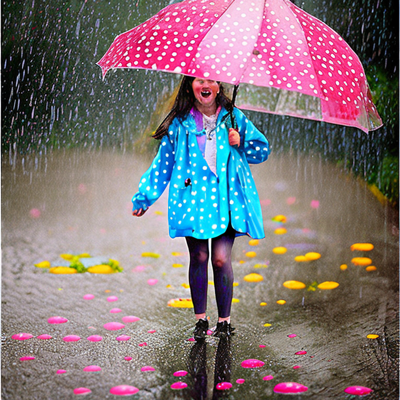

In [109]:
generate_image("Produce a captivating photograph capturing the essence of joy and innocence as a young girl, approximately 8 years old, gleefully plays in the refreshing rain. The scene unfolds in a lush, verdant garden adorned with vibrant flowers and glistening droplets of rain on every surface. The girl, adorned in a colorful, polka-dotted raincoat, twirls gracefully with outstretched arms, her carefree laughter echoing in the air. Envision the raindrops suspended in mid-air, their trajectories frozen in time, highlighting the dynamic energy of the playful moment. The ambient light, softened by the rain clouds, imparts a gentle glow to the surroundings, enhancing the magical and whimsical atmosphere. Capture the authenticity of the child's expression, the sparkle in her eyes, and the subtle reflections of the rain-soaked environment on her radiant face.", image_gen_model)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['landscape. convey a sense of both power and grace, emphasizing the untamed spirit of the animal. pay meticulous attention to details such as the play of light and shadow, ensuring a vivid and lifelike portrayal of this magnificent creature in its untouched wilderness.']


  0%|          | 0/35 [00:00<?, ?it/s]

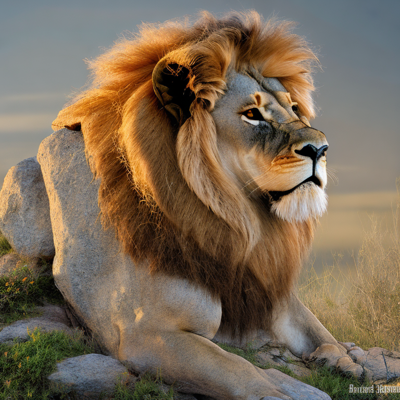

In [110]:
generate_image("Generate a captivating image of a majestic lion in its natural habitat. Envision a vast African savannah, bathed in the warm glow of the setting sun, with the lion standing regally atop a weathered rock formation. Capture the raw beauty of the wild: the lion's mane flowing in the breeze, its amber eyes focused on the horizon, and the rich textures of the grassy landscape. Convey a sense of both power and grace, emphasizing the untamed spirit of the animal. Pay meticulous attention to details such as the play of light and shadow, ensuring a vivid and lifelike portrayal of this magnificent creature in its untouched wilderness.", image_gen_model)

Saving generated images as jpg files

In [111]:
from PIL import Image

def generate_image_and_save(prompt, model, output_path):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)

    # Save the image as a JPG file
    image.save(output_path, "JPEG")

This is the image we will use in the reverse parse to test the model

In [166]:
# Example usage
prompt = "Man walking with his family"
output_path = "/content/drive/My Drive/Colab Notebooks/Final Project/GenImages/img8.jpg"
generate_image_and_save(prompt, image_gen_model, output_path)

  0%|          | 0/35 [00:00<?, ?it/s]

**Image To Text Model**

Importations

In [114]:
import numpy as np
from PIL import Image
import os
import string
import tensorflow as tf
from pickle import dump
from pickle import load
from keras.applications.xception import Xception # to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer # for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, Dense # Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm # to check loop progress
tqdm().pandas()

<ipython-input-114-831d8cffa6fe>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [115]:
from keras.layers import Add

Data preprocessing

In [116]:
# set these path according to project folder in you system,
dataset_text = "/content/drive/My Drive/Colab Notebooks/Final Project"
dataset_images = "/content/drive/My Drive/Colab Notebooks/Final Project/images"

# to prepare our text data
filename = dataset_text + "/" + "captions.txt"

In [117]:
def load_file_into_sting(filename):
   file = open(filename, 'r')
   text = file.read()
   file.close()
   return text

In [118]:
filename = load_file_into_sting(filename)

In [119]:
image_caption_data = filename.split('\n')

In [120]:
def map_image_to_caption(filename):
  #file = load_file_into_sting(filename)

  image_caption_data = filename.split('\n') # split on the newline character
  captions_dict = {}

  for line in image_caption_data[:-1]: # start to -1 because last line in file is empty
    line = line.split(",") # split on the comma
    image_rep, caption = line[0], line[1]

    # sample image rep(resentation) looks like: 1000268201_693b08cb0e.jpg#0
    # and we want only the content before #, hence -2
    image = image_rep[:-2]

    if image not in captions_dict.keys():
      captions_dict[image] = [caption]
    else:
      captions_dict[image].append(caption)

  return captions_dict

In [121]:
a = map_image_to_caption(filename)

In [122]:
len(a.keys())

8089

In [123]:
def clean_text(captions_dict):
  # create mapping table that removes punctuations
  mapping_table = str.maketrans('', '', string.punctuation)

  for image,caption in captions_dict.items():
    for index,caption_text in enumerate(caption):

      caption_text = caption_text.replace("-"," ")

      descp = caption_text.split()

      # uppercase to lowercase
      descp = [word.lower() for word in descp]

      # remove punctuation from each token
      descp = [word.translate(mapping_table) for word in descp]

      # remove hanging 's and a
      descp = [word for word in descp if(len(word)>1)]

      # remove words containing numbers with them
      descp = [word for word in descp if(word.isalpha())]

      # converting back to string
      caption_text = ' '.join(descp)
      captions_dict[image][index] = caption_text

  return captions_dict

In [124]:
def build_vocabulary(captions_dict):
  # to build vocab of all unique words
  vocab = set()

  for image in captions_dict.keys():
    [vocab.update(caption_text.split()) for caption_text in captions_dict[image]]

  return vocab

In [125]:
# to save all captions in one file
def save_captions(captions_dict, filename):
  lines = list()

  for image, caption_list in captions_dict.items():
    for caption_text in caption_list:
      lines.append(image + '\t' + caption_text )

  data = "\n".join(lines)
  file = open(filename, "w")
  file.write(data)
  file.close()

In [126]:
# loading the file that contains all data
# map them into descriptions dictionary
map_imagecaption = map_image_to_caption(filename)
print("Length of Image -> Descriptions Mapping =",len(map_imagecaption))

Length of Image -> Descriptions Mapping = 8089


In [127]:
# cleaning the descriptions
clean_descriptions = clean_text(map_imagecaption)
print("Length of Image -> Descriptions Mapping =",len(clean_descriptions))

Length of Image -> Descriptions Mapping = 8089


In [128]:
vocabulary = build_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8255


Saving captions in the folder

In [129]:
# saving all descriptions in one file
#save_captions(clean_descriptions, "/content/drive/My Drive/Colab Notebooks/Final Project/descriptions.txt")

CNN Model

In [130]:
model = Xception(include_top=False, pooling='avg')

Extracting Features

In [131]:
def extract_features(directory):
  model = Xception( include_top=False, pooling='avg' )
  features = {}
  for picture in tqdm(os.listdir(directory)):
    file = directory + "/" + picture
    image = Image.open(file)
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    # image = preprocess_input(image)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    features[picture] = feature
  return features

Storing extracted features

In [133]:
# 2048 feature vector
#features = extract_features(dataset_images)
#features_path = "/content/drive/My Drive/Colab Notebooks/Final Project/features.p"
#dump(features, open(features_path,"wb"))


In [135]:
# to directly load the features from the pickle file.
features = load(open("/content/drive/My Drive/Colab Notebooks/Final Project/features.p","rb"))

In [136]:
# load the data
def load_photos(filename):
    file = load_file_into_sting(filename)
    photos = [x.split(",")[0] for x in file.split("\n")[:-1]]
    return photos

In [137]:
def load_clean_descriptions(filename, photos):
    # loading clean_descriptions
    file = load_file_into_sting(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []

            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)

    return descriptions

Load features from file

In [138]:
def load_features(photos):
    # loading all features
    all_features = load(open("/content/drive/My Drive/Colab Notebooks/Final Project/features.p","rb"))

    # selecting only needed features
    features = {}

    for k in photo:
      try:
        features.update({k:all_features[k]})
      except KeyError:
        continue

    return features

In [141]:
filename = dataset_text + "/" + "trainImages.txt"
train_imgs = load_photos(filename)
desc_path = "/content/drive/My Drive/Colab Notebooks/Final Project/descriptions.txt"
train_descriptions = load_clean_descriptions(desc_path, train_imgs)
train_features = load_features(train_imgs)


In [142]:
print(len(train_features))

8088


In [143]:
# convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]

    return all_desc

Text preprocessing

In [144]:
# creating tokenizer class
# this will vectorise text corpus
# each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)

    return tokenizer

In [145]:
# give each word an index,
# and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
tokenizer_path = "/content/drive/My Drive/Colab Notebooks/Final Project/tokenizer.p"
dump(tokenizer, open(tokenizer_path, 'wb'))

In [146]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8255


In [147]:
# calculate maximum length of descriptions
# to decide the model structure parameters.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

In [148]:
max_length = max_length(train_descriptions)
print(max_length)

29


In [149]:
# data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        for key, description_list in descriptions.items():
                # retrieve photo features
                feature = features[key][0]
                inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
                yield [[inp_image, inp_seq], op_word]

In [150]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]

        # divide one sequence into various x,y pairs
        for i in range(1, len(seq)):
                # divide into input and output pair
                in_seq, out_seq = seq[:i], seq[i]

                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store
                x_1.append(feature)
                x_2.append(in_seq)
                y.append(out_seq)

    return np.array(x_1), np.array(x_2), np.array(y)

In [151]:
# to check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
print((a.shape, b.shape, c.shape))

((51, 2048), (51, 29), (51, 8255))


LSTM Connection

In [152]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    # decoder1 = Add([fe2, se3])
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/Final Project/model.png', show_shapes=True)

    return model

Training the LSTM model

In [153]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)

Dataset:  40440
Descriptions: train= 8088
Photos: train= 8088
Vocabulary Size: 8255
Description Length:  29
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 29)]                 0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 29, 256)              2113280   ['input_10[0][0]']            
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_9[0][0]

In [ ]:
epochs = 10
steps = len(train_descriptions)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/Final Project/model_mtbest_221123.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode="auto")

generator = data_generator(train_descriptions, train_features, tokenizer, max_length)

history = model.fit(
    generator,
    epochs = epochs,
    callbacks = [checkpointer],
    steps_per_epoch = steps
)

In [154]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")

    image = image.resize((299,299))
    image = np.array(image)

    # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)

    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        if word is None:
            break

        in_text += ' ' + word

        if word == 'end':
            break

    return in_text

**Testing bidirectional translation**

1/1 [==============================] - 1s 716ms/step
nn
start of people are sitting on bench in front of the trees and the sun sets on the ground and the sun sets on it in the background and the


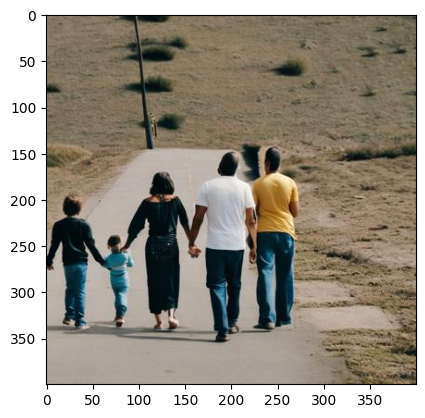

In [167]:
img_path = "/content/drive/My Drive/Colab Notebooks/Final Project/GenImages/img8.jpg"
tokenizer = load(open("/content/drive/My Drive/Colab Notebooks/Final Project/tokenizer.p","rb"))
model = load_model('/content/drive/My Drive/Colab Notebooks/Final Project/model_mtbest_221123.hdf5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)

The initial prompt was:

In [ ]:
print(prompt)

The perceived meaning of the prompt generated by the model was:

In [ ]:
print(description)

**References**

Srinivasan, K., Raman, K., Chen, J., Bendersky, M., & Najork, M. (2021). WIT: Wikipedia-based Image Text Dataset for Multimodal Multilingual Machine Learning. arXiv (Cornell University). http://arxiv.org/pdf/2103.01913.pdf

Team, N., Costa-Jussà, M. R., Cross, J. H., Çelebi, O., Elbayad, M., Heafield, K., Heffernan, K. S., Kalbassi, E., Lam, J., Licht, D. J., Maillard, J., Sun, A., Wang, S., Wenzek, G., Youngblood, A., Akula, B., Barrault, L., Gonzalez, G. M., Hansanti, P., . . . Wang, J. (2022). No language left behind: Scaling Human-Centered Machine Translation. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2207.04672

Touvron, H., Lavril, T., Izacard, G., Martinet, X., Lachaux, M., Lacroix, T., Roziere, B., Goyal, N., Hambro, E., Azhar, F., Rodriguez, A., Joulin, A., Grave, E., & Lample, G. (2023). LLAMA: Open and Efficient Foundation Language Models. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2302.13971

Parida, S., Panda, S., Biswal, S. P., Kotwal, K., Sen, A., Dash, S. R., & Motlicek, P. (2021). Multimodal Neural Machine Translation System for English to Bengali. Proceedings of the FirstWorkshop on Multimodal Machine Translation for Low Resource Languages (MMTLRL 2021).  https://doi.org/10.26615/978-954-452-073-1_006

MandeepKharb. (n.d.). Youtube/GenerativeAI/TextToImageGenerator.ipynb at main · MandeepKharb/Youtube. GitHub. https://github.com/MandeepKharb/Youtube/blob/main/GenerativeAI/TextToImageGenerator.ipynb

